# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
#%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
from tqdm import tnrange, tqdm_notebook

# Seaborn visualization library
import seaborn as sns
def easy_plot_details(axis, title, xlabel, ylabel, subplot = False):
    """
    This function allows for simple plot axis labeling and formating.
    """
    if subplot == True:
        axis.title.set_text(title[0])
        axis.title.set_size(title[1])
        axis.set_xlabel( xlabel[0])
        axis.set_ylabel( ylabel[0])
    else:
        axis.tick_params( labelsize=12)
        axis.set_title(  title[0], fontsize = title[1])
        axis.set_ylabel( ylabel[0], fontsize = ylabel[1])
        axis.set_xlabel( xlabel[0], fontsize = xlabel[1])
    #axis.legend(loc = 'best', fontsize=8);
    



<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
#your code here
cal_train = pd.read_csv("data/calendar_train.csv", parse_dates = True)
cal_test = pd.read_csv("data/calendar_test.csv", parse_dates = True)

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [4]:
cal_train['date'] = pd.to_datetime(cal_train['date'])
cal_test['date'] = pd.to_datetime(cal_test['date'])

days_of_wk = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = [
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

cal_train['month'] = cal_train['date'].apply(lambda x : months[x.month-1])
cal_train['day_of_wk'] = cal_train['date'].apply(lambda x : days_of_wk[x.dayofweek]) 

cal_test['month'] = cal_test['date'].apply(lambda x : months[x.month-1])
cal_test['day_of_wk'] = cal_test['date'].apply(lambda x : days_of_wk[x.dayofweek]) 
cal_train_2 = cal_train.copy()
cal_train_available = cal_train_2[cal_train_2['available'] != 'f']
cal_test_available = cal_test[cal_test['available'] != 'f']

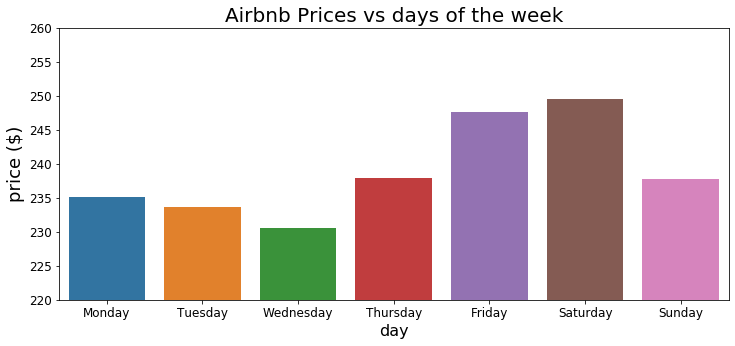

In [5]:
#mean
price_mns_days_of_wk = []
#median
price_med_days_of_wk = []
for day in days_of_wk:
    tmp = cal_train_available[cal_train_available['day_of_wk'] == day]
    price_mns_days_of_wk.append(round(np.mean(tmp['price']),2))
    price_med_days_of_wk.append(round(np.median(tmp['price']),2))
    
days_of_wk_df = pd.DataFrame(np.ones(7))
days_of_wk_df[0] = days_of_wk
days_of_wk_df[1] = price_mns_days_of_wk
days_of_wk_df.columns = ["day","price"]

ax =  fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.barplot(x = "day", y = "price", data = days_of_wk_df) #, showfliers=False
ax.set(ylim=(220, 260))
easy_plot_details(ax, ["Airbnb Prices vs days of the week",20], ["day",16], ["price ($)",18], subplot = False)


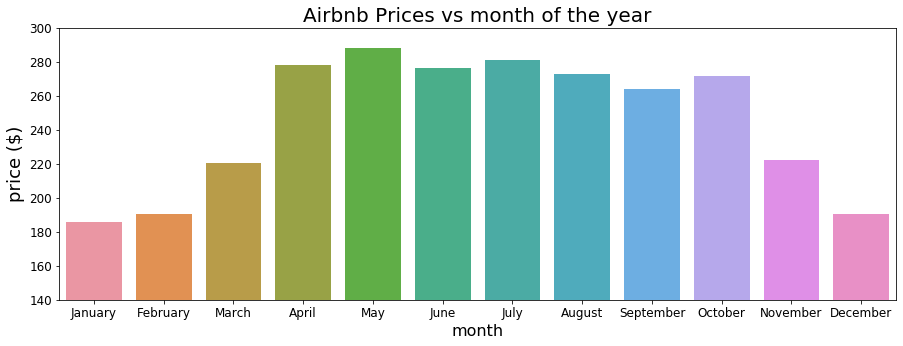

In [6]:
price_mns_months = []
for month in months:
    tmp = cal_train_available[cal_train_available['month'] == month]
    price_mns_months.append(round(np.mean(tmp['price']),2))
    
month_df = pd.DataFrame(np.ones(12))
month_df[0] = months
month_df[1] = price_mns_months
month_df.columns = ["month","price"]

ax =  fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(x = "month", y = "price", data = month_df) #, showfliers=False
ax.set(ylim=(140, 300))
easy_plot_details(ax, ["Airbnb Prices vs month of the year",20], 
                  ["month",16], ["price ($)",18], subplot = False)

**Analysis**

$\bullet$ We can see that for the days of the week, Friday and Saturday are most expensive indicating that prices rise on the weekends. The least expensive day is Wednesday, which is furthest from the weekend (which can be viewed as a weekly mini-vacation).

$\bullet$ We can see that for the months of the year, the winter (January and February) are the least expensive times while the summer (April through August) is the most expensive time.

$\bullet$ If we split the months into two groups (inexpensive vs expensive) then April through October is the expensive period and November through march is the inexpensive period, indicating that many less people visit Boston in the winter.

$\bullet$ This makes sense because people are more likely to travel during summer (vacation time) and the weekend. Also Boston winters are very harsh.

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [7]:
#your code here
df = cal_train_available.sample(n=5000, random_state=1)
num_dates = cal_train_available['date'] - min(cal_train_available['date'] )
num_dates = num_dates.dt.days

num_dates_test = cal_test_available['date'] - min(cal_test_available['date'] )
num_dates_test = num_dates_test.dt.days

### 1. Polynomials

In [8]:
#your code here
#cal_train_available['date'] = pd.to_datetime(cal_train_available['date']) 
X=np.array(num_dates).reshape(-1,1)
y=np.array(cal_train_available['price'])

X_train=np.array(num_dates).reshape(-1,1)

X_test=np.array(num_dates_test).reshape(-1,1)
y_test=np.array(cal_train_available['price'])

In [9]:
train = pd.DataFrame(X)
train.columns = ["date"]
train['price'] = y
train.head()

,date,price
0,178,62.0
1,177,59.0
2,176,75.0
3,175,71.0
4,173,51.0


In [10]:
#this function automatically writes formulas.
def step_down(x, str_x = ""):
    global formula
    if (x == 1):
        str_x = "price ~ date" + str_x
        formula = str_x
        print
    else:
        x =  step_down(x - 1, str_x + " + np.power(date, " + str(x)+")")
        
# now we store the formulas for the necissary powers in a list.
pol_lst = [2,3,5,8]
formula_lst = []
for i in pol_lst:
    step_down(i)
    formula_lst.append(formula)

In [11]:
test = pd.DataFrame(X_test)
test.columns = ["date"]

def df_convertor(lst, lbl):
    df = pd.DataFrame(np.array(lst).reshape(-1,1))
    df.columns = [lbl]
    return df

daily_avgs = []
daily_avgs_test = []
for i in range(max(num_dates) + 1):
    daily_avg = np.mean(cal_train_available['price'][num_dates == i])
    daily_avgs.append(daily_avg)
    
    daily_avg_test = np.mean(cal_test_available['price'][num_dates_test == i])
    daily_avgs_test.append(daily_avg_test)

daily_avgs = df_convertor(daily_avgs, "price")
daily_avgs_test = df_convertor(daily_avgs_test, "price")

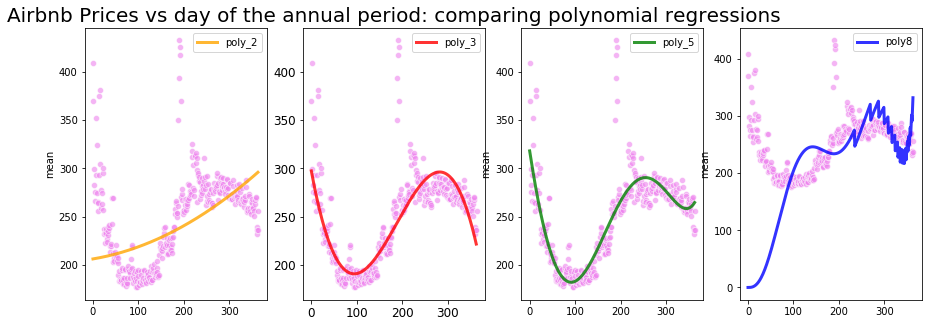

In [12]:
#predict_df = pd.DataFrame(data={"age":x_pred})
#predict_df.head()
dates_ = df_convertor(list(range(max(num_dates))), "date")

poly_models_lst = []

avg_preds  = []
train_preds = []
test_preds = []

for i, expr in enumerate(formula_lst):
    
    # fit the model
    fit_lm = sm.ols(formula = expr, data = train).fit()
    
    #attach it to the list of training models
    poly_models_lst.append(fit_lm)
    
    #avg predictions
    avg_pred = fit_lm.get_prediction(pd.DataFrame(dates_)).summary_frame()
    
    #get training predictions
    train_pred = fit_lm.get_prediction(df_convertor(num_dates, "date")).summary_frame()
    
    #get training predictions
    test_pred = fit_lm.get_prediction(df_convertor(num_dates_test, "date")).summary_frame()
    
    #append everything to lists:
    train_preds.append(train_pred)
    test_preds.append(test_pred)
    avg_preds.append(avg_pred)
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax.flatten()
colors = ["orange", "red", "green","blue"]
names = ["poly_2", "poly_3", "poly_5", "poly8"]
for i, pred_df in enumerate(avg_preds):
    sns.scatterplot(x=list(range(max(num_dates)+1)), y='price', data = daily_avgs, 
                    color = 'violet', alpha = 0.6, ax = ax[i]) 
    sns.lineplot(x = list(dates_['date']), y='mean', data = pred_df,
                 color = colors[i], label = names[i], alpha = 0.8, 
                 sizes = [100],  linewidth=3, ax = ax[i])

easy_plot_details(ax[1], ["Airbnb Prices vs day of the annual period: comparing polynomial regressions",20], ["",16], ["",18], subplot = False)

r2_scores = []
r2_scores_test = []
for i, val in enumerate(train_preds):
    r2_scores.append(r2_score(cal_train_available["price"],val['mean']))
    #test val
    test_val = test_preds[i]
    r2_scores_test.append(r2_score(cal_test_available["price"],test_val['mean']))
r2_df = pd.DataFrame([[2,3,5,8],r2_scores,r2_scores_test]).T
r2_df.columns = ["degree", "train_r2_score", "test_r2_score"]


In [13]:
display(r2_df)

,degree,train_r2_score,test_r2_score
0,2.0,0.018489,0.019180
1,3.0,0.038933,0.038752
2,5.0,0.042100,0.041738
3,8.0,-0.170195,-0.158009


### 2. Degree 8 oddity

## Numeric Instability

# definition from http://mathworld.wolfram.com/NumericalStability.html
**"Numerical stability refers to how a malformed input affects the execution of an algorithm. In a numerically stable algorithm, errors in the input lessen in significance as the algorithm executes, having little effect on the final output."**

# Problem

$\bullet$ The basis set we generate through sm.ols is not orthogonal at high powers which means tiny perterbations in values can lead to a lot of noise in the model. 

*According to TF Cedric when you perform polynomial regression with python it must invert a very unbalanced or ill-conditioned "Vandermonde matrix" that has extremely large numbers (for example 200^8 or 2.56e+18) in the far right column. When the algorithm performs vandermonde matrix inversion large errors result because you are dividing by near zero values. Because of the imprecision of floating point numbers this leads to large errors in the output. While on the surface this looks like multi-colinearity this is associated with the model and not the data, so this is something different.*

$\bullet$ standardization is not a solution because you will lose dynamic range, small numbers will get crushed to 0

# Solution
$\bullet$ Choosing a basis set which is more orthogonal (for example by employing linear combinations of the Legendre polynomials) to reduce numeric instability.

$\bullet$ You can also use splines to reduce numeric instability.

$\bullet$ It's unlikely that the data has a degree 8 relationship, so using lower order polynomials is probably better.

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

Fit a Smoothing spline model in pygam with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [14]:
y = cal_train_available['price']
y = np.array(y)

vals = np.logspace(-3, 0)

kf = KFold(n_splits=5, shuffle = True)
kf.get_n_splits(X)
lam = np.logspace(0, 12)
#lam = [0.1,1]

count = 0
test_r2_scores = []

for i in tqdm_notebook(vals):
    tmp_r2_scores = []
    
    # build linear gam object
    gamm = LinearGAM(lam = i)
    
    # loop through values
    for train_index, test_index in kf.split(X):
        
        # fit linear gam
        gamm.fit(X[train_index], y[train_index])
        
        # predict values
        gam_test_pred_vals = gamm.predict(X[test_index])
        
        # get r^2 value
        test_r2_score  =  r2_score(gam_test_pred_vals, y[test_index])
        
        # append the values to the tmp list
        tmp_r2_scores.append(test_r2_score)
    
    #take the mean and loop through next lambda value.
    test_r2_scores.append(np.mean(tmp_r2_scores))
    count += 1
        


In [15]:
best_lam = vals[test_r2_scores.index(max(test_r2_scores))]
print("best lambda values: " + str(round(best_lam, 4)))

best lambda values: 0.0031


In [16]:
gam = LinearGAM(lam = best_lam) #0.0449648
gam.fit(X,y)

# I abandoned gridsearch.

#lam = np.logspace(-9, 10)
#lams = [lam]*3
#gam.gridsearch(X, y, lam=lam)
#gam.fit(X, y) #0.0449648 0.0449637
#gam.summary()

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [17]:
gam_test_pred_vals = gam.predict(X_test)
gam_train_pred_vals = gam.predict(X)
train_r2_score =  r2_score(cal_test_available["price"],gam_test_pred_vals)
test_r2_score  =  r2_score(cal_train_available["price"],gam_train_pred_vals)
print("cross-val train R^2 score:" + str(round(train_r2_score,6)))
print("cross-val test  R^2 score: " + str(round(test_r2_score,6)))

r2_df2 = pd.DataFrame([[2,3,5,8, "cross-val spline"],
                      r2_scores + [train_r2_score],
                      r2_scores_test + [test_r2_score]]).T
r2_df2.columns = ["degree", "train_r2_score", "test_r2_score"]
display(r2_df2)

cross-val train R^2 score:0.044803
cross-val test  R^2 score: 0.044965


,degree,train_r2_score,test_r2_score
0,2,0.0184886,0.0191804
1,3,0.0389329,0.0387518
2,5,0.0421003,0.0417383
3,8,-0.170195,-0.158009
4,cross-val spline,0.0448026,0.0449648


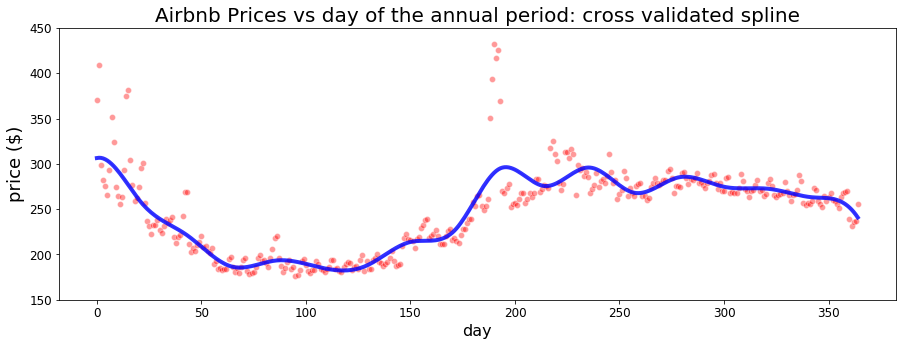

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.scatterplot(x=list(range(max(num_dates)+1)), y='price', data = daily_avgs
                , color = 'red', alpha = 0.4) 
sns.lineplot(x=num_dates_test, y=gam_test_pred_vals, color = "blue", alpha = 0.8,  linewidth=4)
ax.set(ylim=(150, 450))
easy_plot_details(ax, ["Airbnb Prices vs day of the annual period: cross validated spline",20], ["day",16], ["price ($)",18], subplot = False)


Below I plot various smoothing parameters, with the cross-validated spline line plotted in white. As you can see it closely tracks the line with barely any smoothing at all.

0
1000000


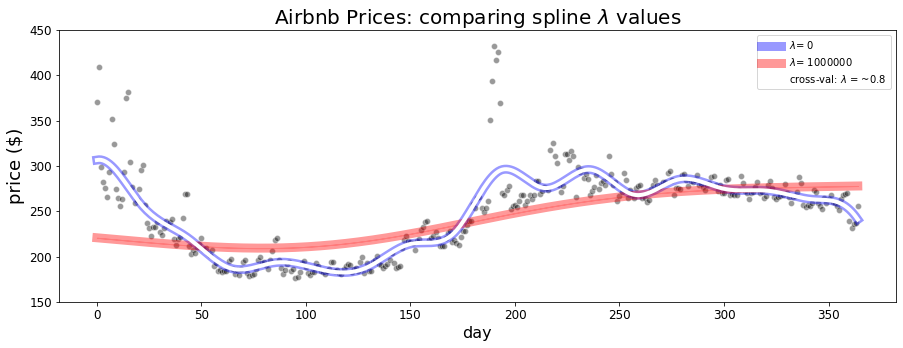

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set(ylim = (150, 450))
sns.scatterplot(x=list(range(max(num_dates)+1)), y='price', 
                data = daily_avgs, color = 'black', alpha = 0.4)
cols = ["blue", "red"]
for j, i in enumerate([0,1000000 ]): #[np.exp(-10 + 2*i) for i in range(11) ]:
    print(i)
    gam = LinearGAM(s(0), lam = i).fit(X,y)
    gam_test_pred_vals_ = gam.predict(X_test)
    sns.lineplot(x=num_dates_test, y=gam_test_pred_vals_, color = cols[j], 
                 alpha = 0.4, dashes=(2, 2),  linewidth=9, label = "$\lambda$= " + str(i))
    
sns.lineplot(x=num_dates_test, y=gam_test_pred_vals, 
             color = "white", alpha = 1,  linewidth=4, label = "cross-val: $\lambda$ = ~0.8")
easy_plot_details(ax, ["Airbnb Prices: comparing spline $\lambda$ values",20], 
                  ["day",16], ["price ($)",18], subplot = False)


### 4. Effects of parameters

# Of the models, which performs the best? 

As we can see below, in the test_r2_scores among the models, the cross-validated spline is the best performing model.

In [20]:
display(r2_df2)

,degree,train_r2_score,test_r2_score
0,2,0.0184886,0.0191804
1,3,0.0389329,0.0387518
2,5,0.0421003,0.0417383
3,8,-0.170195,-0.158009
4,cross-val spline,0.0448026,0.0449648


# What is the effect of the tuning parameters (degree and smoothness penalty)?

**The effect of the tuning parameters (degree and smoothness penalty) changes:**

1) the expressivity of the model and 

2) the smoothness of the model.

$\bullet$ Specifically, the $\lambda$ parameter is a regularization term that penalizes the 2nd derivative of the function. By increasing lambda we reduce the curviness of the model. In the case above, with a best $\lambda$ value of 0.1, which is close to 0, we penalized the curve very little.

$\bullet$ There are clearly problems with increasing the degree of the polynomials too much and we are better off using smoothing splines. However, curves of 3 degrees provide expressivity while also providing the optimal solution to the penalty fuction laid out by the smoothing spline penalty function.

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [21]:
#your code here
def is_weekend(df_tmp):
    df_ = df_tmp.copy()
    sat = df_["day_of_wk"] == "Saturday" 
    sun = df_["day_of_wk"] == "Sunday" 
    wknd = np.logical_or(sat,sun)
    #df_ = ["weekend"] = weekend
    return(wknd)

train_wknd = is_weekend(cal_train_available)
test_wknd  = is_weekend(cal_test_available)

X_new = np.append(X, np.array(train_wknd).reshape(-1,1),1)
X_new_test = np.append(X_test, np.array(test_wknd).reshape(-1,1),1)

In [22]:
gam=LinearGAM(terms='auto', max_iter=100, tol=0.0001, 
              fit_intercept=True, verbose=False, lam = best_lam)
lam = np.logspace(-9, 10)
lams = [lam]*3 #Kfold
gam.fit(X_new,y)
#gam.gridsearch(X_new, y)
#gam.summary()

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

,degree,train_r2_score,test_r2_score
0,2,0.0184886,0.0191804
1,3,0.0389329,0.0387518
2,5,0.0421003,0.0417383
3,8,-0.170195,-0.158009
4,cross-val spline,0.0448026,0.0449648
5,wknd_adj_spline,0.0452427,0.0450198


Text(0.5, 0, 'model')

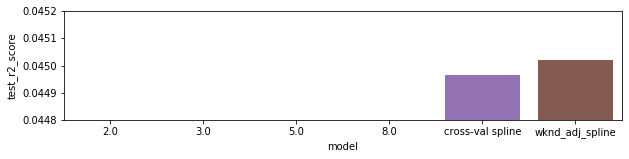

In [23]:
gam_test_pred_vals_wknd = gam.predict(X_new_test)
gam_train_pred_vals_wknd = gam.predict(X_new)

wk_r2_test = r2_score(cal_test_available["price"], gam_test_pred_vals_wknd)
wk_r2_train = r2_score(cal_train_available["price"], gam_train_pred_vals_wknd)

r2_df2 = pd.DataFrame([[2,3,5,8, "cross-val spline", "wknd_adj_spline"],
                      r2_scores + [train_r2_score, wk_r2_train],
                      r2_scores_test + [test_r2_score, wk_r2_test ]]).T
r2_df2.columns = ["degree", "train_r2_score", "test_r2_score"]
display(r2_df2)


fig, ax = plt.subplots(1, 1, figsize=(10, 2));
sns.barplot(x='degree', y = 'test_r2_score', data = r2_df2)
ax.set_ylim([0.0448,0.0452])
ax.set_xlabel("model")

# *As seen above, the weekend adjusted indicator variable has a higher r^2 value than the cross-validated spline. *

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


first day of recorded values: 2017-10-06 00:00:00


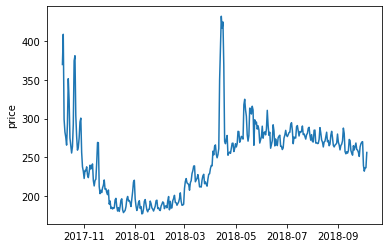

In [24]:
#your code here
dtidx = pd.DatetimeIndex(np.unique(cal_train_available['date']))
dff = pd.DataFrame(list(daily_avgs['price']), dtidx )
dff.columns =["price"]

dff.head(10)
dff["date"]=dtidx

dff.sort_values(by=['price'], ascending = False).head(10)


sns.lineplot(x = dtidx, y = "price",data = dff)
print("first day of recorded values: " + str(min(cal_train_available['date'])))

$\bullet$ The Boston Marathon was on April 16, 2018. This explains that result, as well as the dates (4/14 -> 4/17) immediately surrounding it.  
$\bullet$ The other high priced dates appear at the beggining of the timeframe (10/6/17) was the first date recorded, and as the plot below shows, those dates have less overall airbnbs available. Perhaps this contributed to the noise in the data that we can see in the plot above.

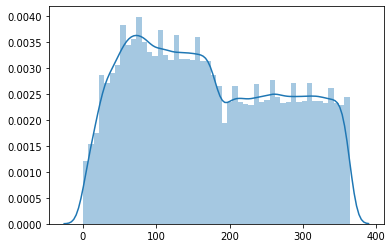

In [25]:
sns.distplot(list(num_dates))

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [26]:
#your code here
train_listing = pd.read_csv("data/listings_train.csv")
test_listing  = pd.read_csv( "data/listings_test.csv")

## Does it appear that some of the predictors have a nonlinear relationship with the response variable? 

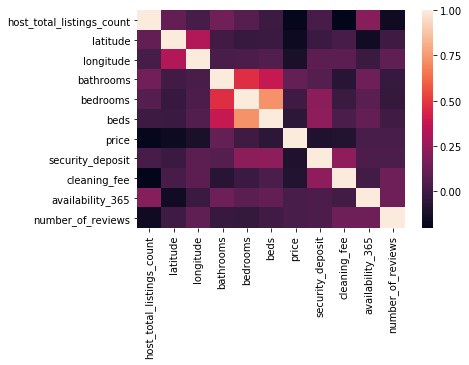

In [27]:
sns.heatmap(train_listing.corr()) # default is pearson correlation coefficient which is a measure of 

$\bullet$ Because the pearson correlation (the default pandas .corr method) coefficient measures linear correlation and often misses non-linear relationships, we can take the "dark" or near 0 values of the values in the price row to mean that these relationships are mostly non-linear. Bathrooms appears brightest, but the discrete nature of that variable doesn't lend itself directly to linearity.

$\bullet$ I also plotted the predictors vs price in a matrix below and no linear relationships jumped out. Thus, all appear to have non-linear relationships, if they exist.

$\bullet$ However, I do think that if you were to fit a linear regression to some of these columns, bathrooms and bedrooms would be the primary candidates.

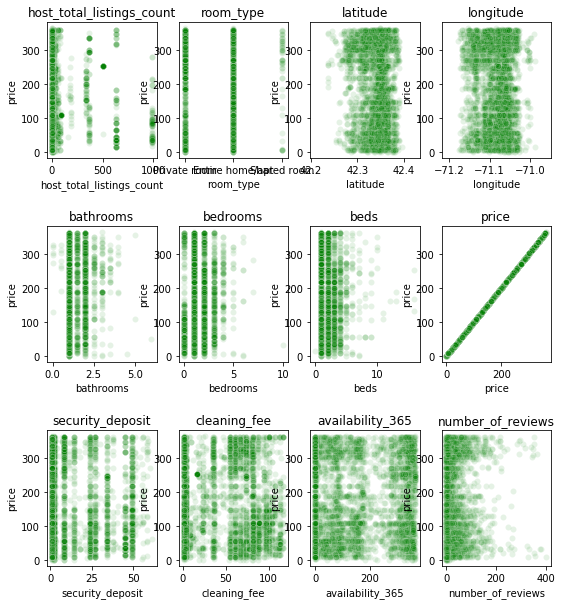

In [28]:
cols = list(train_listing.columns)

fig, axs = plt.subplots(3, 4, figsize=(10, 10));
axs = axs.flatten()
for i, ax in enumerate(axs):
    sns.scatterplot(x = cols[i], y ='price', 
                    data = train_listing, ax = axs[i], alpha = 0.1, color = 'green')
    axs[i].set_title(cols[i])
fig.subplots_adjust(hspace = 0.5, left = 0.2)

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [29]:
train_listing.dtypes
quant_cols = train_listing.select_dtypes(exclude='object').columns
str_cols = train_listing.select_dtypes(include='object').columns
quant_cols = list(quant_cols)

# recursive function that builds the formula:
def step_down2(x, string, str_x = ""):
    global formula
    if (x == 1):
        str_x = string +  str_x
        formula = str_x
    else:
        x =  step_down2(x - 1, string, str_x + " + np.power(" + string  + ", " + str(x)+")")
step_down2(6, "date")
formula

formula_ = ""
formula_poly = ""
for col_name in quant_cols:
    if col_name != 'price':
        step_down2(3, col_name)
        if formula_poly == "":
            formula_poly = formula_poly + formula
        else:  
            formula_poly = formula_poly +" + "+ formula
        step_down2(1, col_name)
        if formula_ == "":
            formula_ = formula_ + formula
        else:  
            formula_ = formula_ +" + "+ formula
formula_poly = "price ~ " + formula_poly + " + " + str_cols[0]
formula_ = "price ~ " + formula_ + " + " + str_cols[0]
formula_poly

'price ~ host_total_listings_count + np.power(host_total_listings_count, 3) + np.power(host_total_listings_count, 2) + latitude + np.power(latitude, 3) + np.power(latitude, 2) + longitude + np.power(longitude, 3) + np.power(longitude, 2) + bathrooms + np.power(bathrooms, 3) + np.power(bathrooms, 2) + bedrooms + np.power(bedrooms, 3) + np.power(bedrooms, 2) + beds + np.power(beds, 3) + np.power(beds, 2) + security_deposit + np.power(security_deposit, 3) + np.power(security_deposit, 2) + cleaning_fee + np.power(cleaning_fee, 3) + np.power(cleaning_fee, 2) + availability_365 + np.power(availability_365, 3) + np.power(availability_365, 2) + number_of_reviews + np.power(number_of_reviews, 3) + np.power(number_of_reviews, 2) + room_type'

In [30]:
fit_lm = sm.ols(formula = formula_, data = train_listing ).fit()
fit_lm_poly = sm.ols(formula = formula_poly, data = train_listing ).fit()

#get training predictions
train_pred = fit_lm.get_prediction(train_listing).summary_frame()
    
#get training predictions
test_pred = fit_lm.get_prediction(test_listing.drop(['price'], axis = 1)).summary_frame()

#get training predictions
train_pred_poly = fit_lm_poly.get_prediction(train_listing).summary_frame()
    
#get training predictions
test_pred_poly = fit_lm_poly.get_prediction(test_listing.drop(['price'], axis = 1)).summary_frame()


poly_r2_score = r2_score(test_listing["price"],test_pred_poly['mean'])
lin_r2_score = r2_score(test_listing["price"],test_pred['mean'])

scores = [lin_r2_score, poly_r2_score]
score_names = ["linear", "polynomial"]

dff = pd.DataFrame(scores,score_names)
dff.columns = ["test set r2 score"]

display(dff)

,test set r2 score
linear,0.184791
polynomial,0.237832


# $\bullet$ Clearly the polynomial model outperforms the linear model in terms of r^2 score: ~0.24 > ~0.18. These higher dimensional models dominate the models from part 1, as expected.

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


_your answer here_

# 2b1

$\bullet$ Yes there is an advantage, additive models are much more expressive than polynomial models via their more complex non-linearity and the way in which they divide the frame with knots. 

$\bullet$ They are also less likely to overfit and fail to perform well at the boundaries of the data (near the minimum and maximum data points).

$\bullet$ splines and general additive models are less likely to be subject to numeric instability than polynomial regression but at the same time can describe much more complex relationships. They can be many smooth combinations of polynomial models, which are a subset of GAMS

# 2b2


In [31]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here
le = LabelEncoder()
le_test = LabelEncoder()

train_listing2 = train_listing.copy()
X_ = np.array(train_listing2.drop(['price'], axis = 1))
le.fit(X_[:,1])
encoded_rooms = le.transform(X_[:,1])
X_[:,1]
encoded_rooms
pd.DataFrame(X_)

train_listing2['room_type'] = encoded_rooms


le_test.fit(test_listing['room_type'])
test_listing2 = test_listing.copy()

test_listing2['room_type'] = le_test.transform(test_listing['room_type'])

gam = LinearGAM(terms=s(0) + f(1) + s(2) + s(3) + s(4) + s(5) +
                s(6) + s(7) + s(8) + s(9) + s(10), 
                max_iter=100, tol=0.0001, fit_intercept=True, verbose=False )
lam = np.logspace(-9, 10)
lams = [lam]*3
y=train_listing['price']

le.fit(y)
#gam.gridsearch(np.array(train_listing2.drop(['price'], axis = 1)), y, lam=lam)
#gam.fit(np.array(train_listing2.drop(['price'], axis = 1)),list(y))
#gam.summary()

LabelEncoder()

I decided against using gridsearch based on posts on Ed. Below is kfold:



In [74]:
# kfold cross validation for lambda:

kf = KFold(n_splits=3, shuffle = True)
XXX = np.array(train_listing2.drop(['price'], axis = 1))
kf.get_n_splits(XXX)
vals = np.logspace(0, 12)

count = 0
test_r2_scores = []

from tqdm import tnrange, tqdm_notebook

test_r2_scores = []
#vals = np.linspace(0,0.3)
vals = [0] + list(np.logspace(-4,0)) + [100]

for i in tqdm_notebook(vals):
    tmp_r2_scores = []
    gamm = LinearGAM(lam = i)
    for train_index, test_index in kf.split(XXX):
        gamm.fit(XXX[train_index], y[train_index])
        gam_test_pred_vals = gamm.predict(XXX[test_index])
        test_r2_score  =  r2_score(gam_test_pred_vals,
                                   y[test_index])
        tmp_r2_scores.append(test_r2_score)
    test_r2_scores.append(np.mean(tmp_r2_scores))
    count += 1

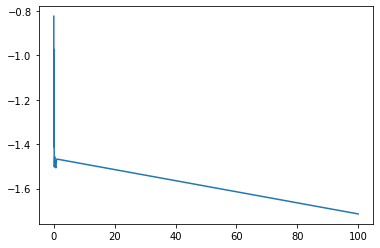

In [75]:
sns.lineplot(x= vals, y = test_r2_scores)

In [76]:
best_lam = vals[test_r2_scores.index(max(test_r2_scores))]
print("best lambda value: " + str(round(best_lam, 5)))

test_r2_scores.index(max(test_r2_scores))

best lambda value: 0


0

In [77]:
gam = LinearGAM(lam = 0.1,
               terms=s(0) + f(1) + s(2) + s(3) + s(4) + s(5) +
                s(6) + s(7) + s(8) + s(9) + s(10)) #0.0449648
y = train_listing['price']
gam.fit(XXX,y)
#train
gam_train_pred_vals = gam.predict(np.array(train_listing2.drop(['price'], axis = 1)))
train_r2_score =  r2_score(train_listing["price"],gam_train_pred_vals)

#test
gam_test_pred_vals = gam.predict(np.array(test_listing2.drop(['price'], axis = 1)))
test_r2_score  =  r2_score(test_listing["price"], gam_test_pred_vals)
print("cross-val train R^2 score:" + str(round(train_r2_score,6)))
print("cross-val test  R^2 score: " + str(round(test_r2_score,6)))


cross-val train R^2 score:0.303092
cross-val test  R^2 score: 0.242895


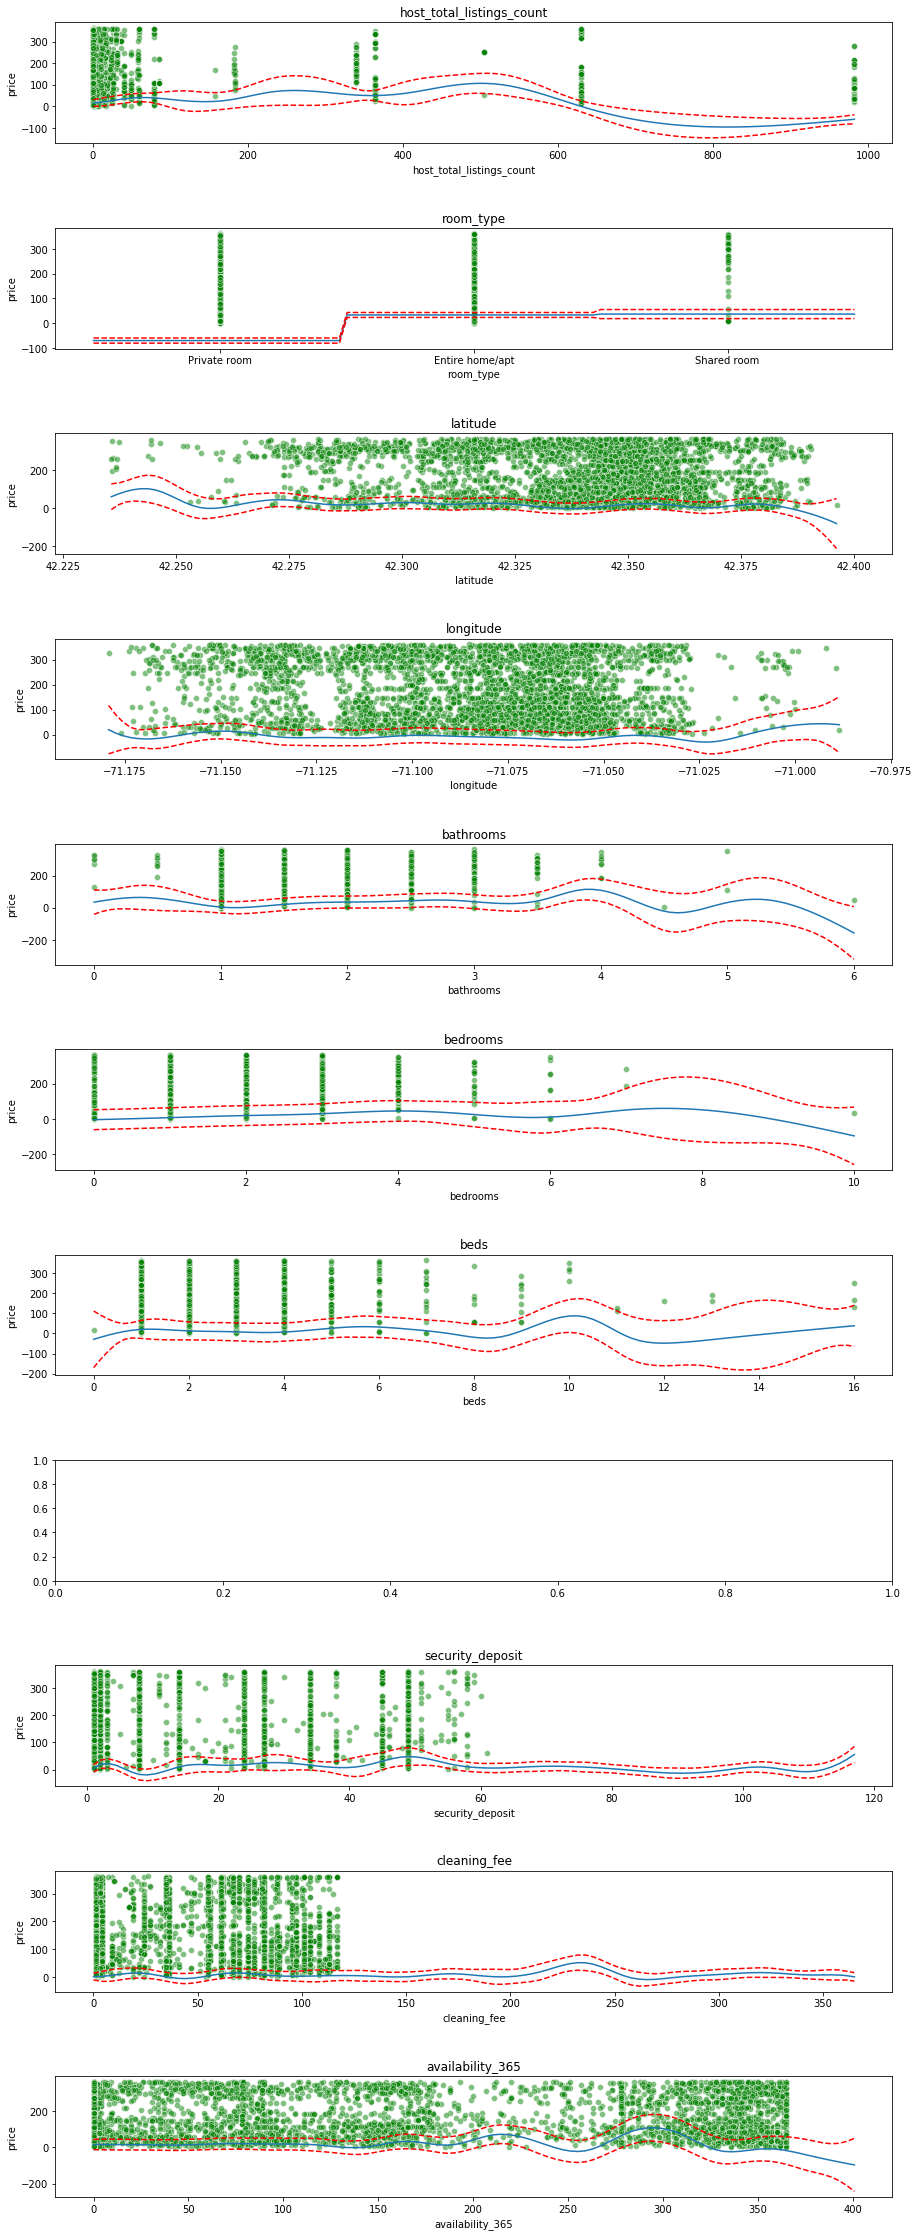

In [78]:
fig, axs = plt.subplots(len(cols) -1, 1, figsize=(15, 40));
terms = list(gam.terms)
axs.flatten()
for i, ax in enumerate(axs):
    if (str(terms[i]) == 'intercept_term') or (str(cols[i]) == 'price'):
        continue
    XX = gam.generate_X_grid(term=i)
    sns.scatterplot(x = cols[i], y ='price', data = train_listing, ax = ax, alpha = 0.5, color = 'green')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(cols[i])
fig.subplots_adjust(hspace = 0.7)

These plots allow us to visualize the marginal relationships in this complex and high dimensional model. I feel that the more specific insights of the model are summarized well in my advice to the traveler in the next problem.

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

## Change the categorical random variable

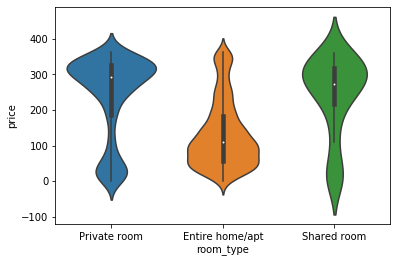

In [79]:
sns.violinplot(x = 'room_type', y ='price', data = train_listing)

Clearly entire home/ apartment is less expensive overall than the category of private room and shared room. However, private room is bi-modal, with a large bulge near the bottom suggesting that the least expensive rooms are potentially private rooms. Shared rooms are actually even cheaper still at the extreme, we see their minimum the lowest of any room type.

# Advice to traveler

$\bullet$ don't come durring the Boston marathon, prices are more expensive.

$\bullet$ If you are willing to stay in a hostel, airbnbs with A LOT of bedrooms (~10) of bathrooms (>4) potentially have cheaper savings, though don't rent a mansion by mistake.

$\bullet$ The cheapest rooms are likely to be private rooms or shared rooms, though you have to go deal hunting for these places. Private rooms will on average be more expensive. This is an example when a violin plot is far more revealing than a boxplot.

$\bullet$ If a host has 600 or more listings, their place will tend to be cheaper. Otherwise target near 0 listings. The range 200-600 appears to be more expensive overall.

$\bullet$ Try to avoid expensive hidden cleaning fees, however a ten dollar fee should give you the minimum in price. If I'm not mistaken, cleaning fees aren't included in the price so try in general to minimize this cost.

$\bullet$ security deposit: global minimum around $8

$\bullet$ availability_365: global minimum around 335 days

# p-values? Most important variables driving the process.

The above traits were the columns with the lowest (P > X) values in the pygam model summary, meaning they were likely  the most significant predictors with regards to determining the price of the airbnb. However, I wasn't able to fully confirm this so I'm putting it last.
To see this table, go to the bottom.

According to these values, assuming we can interpret them this way the most significant predictors were 

$\bullet$ host_total_listings_count   

$\bullet$ room_type

$\bullet$ bathrooms 

$\bullet$ cleaning_fee

In addition to these, from the first part, these variables are also highly important

$\bullet$ Month of the year

$\bullet$ Day of the Week

In [80]:
#host_total_listings_count, room_type
a=train_listing2.drop(['price'], axis = 1).columns[0]
b=train_listing2.drop(['price'], axis = 1).columns[1]
c=train_listing2.drop(['price'], axis = 1).columns[4]
d=train_listing2.drop(['price'], axis = 1).columns[8]
print(a + ", " + b + ", " + c + " , " + d)

host_total_listings_count, room_type, bathrooms , cleaning_fee


In [81]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    137.6439
Link Function:                     IdentityLink Log Likelihood:                                -44044.9148
Number of Samples:                         4370 AIC:                                            88367.1173
                                                AICc:                                           88376.2706
                                                GCV:                                            10078.2079
                                                Scale:                                           9508.4714
                                                Pseudo R-Squared:                                   0.3031
Feature Function                  Lam

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.
